# Imports

In [143]:
# Imports
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import ipywidgets as ipw
import base64
from random import randint
from pynq import Clocks
import xrfdc
import os

# Use base overlay

In [144]:
# Use the RFSoC overlay
from pynq.overlays.base import BaseOverlay

base = BaseOverlay('base.bit')

# Start RF clocks
base.init_rf_clks()
# help(Clocks)
# help(base)



# Channels
#print("Transmitter channels:\n",base.radio.transmitter.get_channel_description())
DAC_CHANNEL_B = 0 # 'Channel 0': {'Tile': 224, 'Block': 0}
DAC_CHANNEL_A = 1 # 'Channel 1': {'Tile': 230, 'Block': 0}

#print("Receiver channels:\n",base.radio.receiver.get_channel_description())
ADC_CHANNEL_D = 0 # 'Channel 0': {'Tile': 224, 'Block': 0}
ADC_CHANNEL_C = 1 # 'Channel 1': {'Tile': 224, 'Block': 1}
ADC_CHANNEL_B = 2 # 'Channel 2': {'Tile': 226, 'Block': 0}
ADC_CHANNEL_A = 3 # 'Channel 3': {'Tile': 226, 'Block': 1}

# Choose variables
Take caution if changing any of these throughout the notebook. We choose to bypass the decimator to achieve higher definition time plots of incoming signals.

In [145]:
# Set the center frequency and sampling frequency

center_frequency = 1240e6  # Hz Frequency of carrier signal
number_samples = 32768  # Between 16 and 32768
decimation_factor = 1 # 2 is default
sample_frequency = 4915.2e6/decimation_factor  # Hz The default sample frequency is 4915.2e6 Hz which is sufficient for our signal

base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.DecimationFactor = decimation_factor

print("Default ADC MixerSettings: ", base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings)
print("Default ADC DecimationFactor: ", base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.DecimationFactor)
print("Default and nonconfigurable ADC sampling frequency is 4915.2 MHz")

Default ADC MixerSettings:  {'Freq': -1228.8, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 1, 'MixerType': 2}
Default ADC DecimationFactor:  1
Default and nonconfigurable ADC sampling frequency is 4915.2 MHz


# Helper Functions

In [146]:
# Function to plot real and imaginary data in time domain
def plot_complex_time(data, n, fs=sample_frequency, 
                      title='Complex Time Plot'):
    plt_re_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.real(data), name='Real'))
    plt_im_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.imag(data), name='Imag'))
    return go.FigureWidget(data = [plt_re_temp, plt_im_temp],
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Seconds (s)',
                                         'autorange' : True},
                                     'yaxis': {
                                         'title': 'Amplitude (V)'}})


def plot_time(data, n, fs=sample_frequency, 
                      title='Time Plot'):
    plt_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = data))
    return go.FigureWidget(data = plt_temp,
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Seconds (s)',
                                         'autorange' : True},
                                     'yaxis': {
                                         'title': 'Amplitude (V)'}})

# Functions
# Function to convert integer to binary array
def int_to_binary_array(num, num_bits):
    return np.array(list(format(num, f'0{num_bits}b')), dtype=int)

# Function to convert binary array to integer
def binary_array_to_int(binary_array):
    return int(''.join(map(str, binary_array)), 2)

# Function to generate message with buffer
def _create_buffer(data=np.array([72, 101, 108, 108, 111,  32,  87, 111, 114, 108, 100,  33], dtype=np.uint8), eof=1, padding=0):
        """Create a buffer that is loaded user data. Append the Extended Barker sequence
        to the user data and then pad with zeros
        """
        frame_number = 0
        random_size = 10
        flags = eof
        if data.size == 0:
            raise ValueError('Message size should be greater than 0.')
        msg = np.array(data, dtype=np.uint8)
        # Append Barker and Random Data
        bkr = np.array([0, 0, 63, 112, 28, len(msg) + 5, frame_number, flags, 5, len(msg), padding], dtype=np.uint8)
        rnd = np.array([randint(0, 255) for p in range(0, random_size)], dtype=np.uint8)
        seq = np.append(bkr, msg)
        seq = np.append(rnd, seq)
        pad = np.append(seq, np.zeros(int(np.ceil((len(rnd) + len(bkr) + len(msg))/32) * 32 - (len(rnd) + len(bkr) + len(msg))), dtype=np.uint8))
        buf = allocate(shape=(len(pad),), dtype=np.uint8)
        buf[:] = pad[:]
        return buf

# Adjust mixer settings to bypass both the coarse and fine mixers in order to inspect raw carrier signal

In [147]:
base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings = {
    'CoarseMixFreq':  xrfdc.COARSE_MIX_BYPASS,
    'EventSource':    xrfdc.EVNT_SRC_TILE, 
    'FineMixerScale': xrfdc.MIXER_SCALE_1P0,
    'Freq':           0.0,
    'MixerMode':      xrfdc.MIXER_MODE_R2C,
    'MixerType':      xrfdc.MIXER_TYPE_COARSE,
    'PhaseOffset':    0.0
}

# Print mixer settings needed to inspect carrier
print("ADC MixerSettings with both mixers bypassed: ", base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings)

ADC MixerSettings with both mixers bypassed:  {'Freq': 0.0, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 16, 'MixerMode': 3, 'FineMixerScale': 1, 'MixerType': 1}


# Sample the carrier signal

In [148]:
# Sample carrier signal

carrier_data = []  # Storage for incoming real data
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    carrier_data.append(base.radio.receiver.channel[i].transfer(number_samples))
    
# Plotting raw data in the time domain
figs = [] # Storage for ADC time domain plots

# Add plots to figs
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_complex_time(
        data=carrier_data[i], 
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel ', str(i), ' Carrier Signal'])))
    
# THIS SHOULD LOOK LIKE THE CARRIER SIGNAL
print("Measured peak 2 peak amplitude: 431.8 mV")
print("Measured frequency: 1.2334 GHz")
print("Measured period: .811 ns")
    
# plot ADC real time domain data
ipw.VBox(figs)

Measured peak 2 peak amplitude: 431.8 mV
Measured frequency: 1.2334 GHz
Measured period: .811 ns


    'data': [{'name': 'Real',
              'type': 'scatter',
              'ui…

# Work in progress: Spectrum Analyzer not looking right with current settings

In [150]:
# Perform and plot FFT of carrier signal

from rfsystem.spectrum_sweep import SpectrumAnalyser

analysers = []
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    analysers.append(
        SpectrumAnalyser(channel = base.radio.receiver.channel[i],
                         sample_frequency = sample_frequency,
                         number_samples = number_samples,
                         title = ''.join(['Spectrum Analyser Channel ',
                                          str(i)]),
                         height = None,
                         width = None))

ipw.VBox([analyser.spectrum_plot.get_plot() for analyser in analysers])

    'data': [{'name': 'Spectrum',
              'type': 'scatter',
             …

1251.45MHz is actual seen frequency

# Adjust mixer settings to do carrier demodulation
Attempt using coarse mixer first since 4915.2MHz/4 = 1228.8MHz which is almost 1240MHz. We should see a frequency offset of approximately 11.2 MHz which for visualization purposes is fine. However, the fine mixer is likely more optimal. 'Freq' should be set to 1240 (MHz) if fine is used.

In [158]:

base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings = {
    'CoarseMixFreq':  xrfdc.COARSE_MIX_SAMPLE_FREQ_BY_FOUR,
    'EventSource':    xrfdc.EVNT_SRC_TILE, 
    'FineMixerScale': xrfdc.MIXER_SCALE_1P0,
    'Freq':           0.0,
    'MixerMode':      xrfdc.MIXER_MODE_R2C,
    'MixerType':      xrfdc.MIXER_TYPE_COARSE,
    'PhaseOffset':    0.0
}
# Print mixer settings for demodulating carrier
print("ADC MixerSettings: ", base.radio.receiver.channel[ADC_CHANNEL_D].adc_block.MixerSettings)

ADC MixerSettings:  {'Freq': 0.0, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 4, 'MixerMode': 3, 'FineMixerScale': 1, 'MixerType': 1}


# Sample and mix the carrier signal down to baseband

In [159]:
baseband_data = []  # Storage for incoming I and Q data
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    baseband_data.append(base.radio.receiver.channel[i].transfer(number_samples))
#print(raw_data[ADC_CHANNEL_D])
#print("raw_data: ", raw_data[ADC_CHANNEL_D])
#print("number_samples: ", number_samples)

In [160]:
# Plotting baseband data in the time domain

figs = [] # Storage for ADC time domain plots

# Add plots to figs
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    figs.append(plot_complex_time(
        data=baseband_data[i], 
        n=number_samples,
        title=''.join(['Time Domain Plot of ADC Channel ', str(i), ' "Baseband" Signal'])))
    
# plot ADC real and imaginary time domain data
ipw.VBox(figs)

# THESE SHOULD LOOK LIKE THE MODULATED WAVES

    'data': [{'name': 'Real',
              'type': 'scatter',
              'ui…

# FFT of baseband signal

In [161]:
from rfsystem.spectrum_sweep import SpectrumAnalyser

analysers = []
#for i in range(0, len(base.radio.receiver.channel)): # Show all plots
for i in range(0, ADC_CHANNEL_D+1): # Show only ADC D
    analysers.append(
        SpectrumAnalyser(channel = base.radio.receiver.channel[i],
                         sample_frequency = sample_frequency,
                         number_samples = number_samples,
                         title = ''.join(['Spectrum Analyser Channel ',
                                          str(i)],),
                         height = None,
                         width = None))

ipw.VBox([analyser.spectrum_plot.get_plot() for analyser in analysers])


    'data': [{'name': 'Spectrum',
              'type': 'scatter',
             …

Offset of 22.2 MHz is because actual seen frequency from carrier FFT was 1251MHz rather than 1240MHz. 1251MHz-1228.8MHz = 22.2MHz

# Symbol to bit mapping

In [155]:
# Parameters for baseband demodulation - NEED TO CHECK ON ALL OF THESE, HOW DO WE MATCH TO OUR BASEBAND SIGNAL?

# bit rate 
# HackRF parameters: Sample Rate = 4 MHz, Symbol Rate = 1 MHz, Interpolation = 2 MHz, Decimation/Sample Rate = 48 kHz
br = 50000  # Is this set to sample_frequency? 

# carrier frequency
f = br      # Is this set to center_frequency?
# bit duration
T = 1/br    # What is this?

bits_per_symbol = 2 # For QPSK


In [156]:
# Demodulate using in phase and quadrature data from ADC D
Rx_data = np.array([])
Rx_in_data = np.array([])
Rx_qd_data = np.array([])
Z_in = np.array([])
Z_qd = np.array([])



for i in range(len(downconverted_data[ADC_CHANNEL_D])//bits_per_symbol):
    # Inphase coherent detector
    Z_in = np.append(Z_in, baseband_data[ADC_CHANNEL_D].real[i*99:(i+1)*99])
    Z_in_intg = np.trapz(Z_in) * (2 / T) # Finding average value?
    #print(Z_in_intg)
    if Z_in_intg > 0:
        Rx_in_data = np.append(Rx_in_data, 1)
    else:
        Rx_in_data = np.append(Rx_in_data, 0)

    # Quadrature coherent detector
    Z_qd = np.append(Z_qd, baseband_data[ADC_CHANNEL_D].imag[i*99:(i+1)*99])
    Z_qd_intg = np.trapz(Z_qd) * (2 / T) # Finding average value?
    #print(Z_qd_intg)
    if Z_qd_intg > 0:
        Rx_qd_data = np.append(Rx_qd_data, 1)
    else:
        Rx_qd_data = np.append(Rx_qd_data, 0)
    Rx_data = np.append(Rx_data, [Rx_in_data[i], Rx_qd_data[i]])

#print("Z_in: ", Z_in)
# print("Z_qd: ", Z_qd)
# print("length of Z_in: ", len(Z_in))
# print("Rx_in_data: ", Rx_in_data)
# print("length of Z_qd: ", len(Z_qd))
# print("Rx_qd_data: ", Rx_qd_data)
# print("length of Rx_data: ", len(Rx_data))
# print("Rx_data: ", Rx_data)


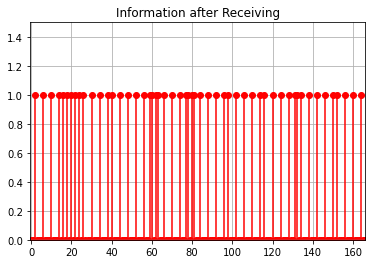

Received binary:  [0. 0. 1. ... 0. 1. 0.]
actual_word:  [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
Bit Error Rate: 51.35135135135135%


In [157]:
# Plot binary

plt.figure()
plt.stem(range(len(Rx_data)), Rx_data, linefmt='r-', markerfmt='ro')
plt.title('Information after Receiving')
plt.axis([-.5, len(Rx_data)/99 + .5, 0, 1.5])
plt.grid(True)
plt.show()

# Calculate BER
print("Received binary: ", Rx_data)
number_bytes = 23
original_message_length = number_bytes*8
actual_word = np.array([])
for i in range(0, original_message_length+1):
    actual_word = np.append(actual_word, Rx_data[i])
print("actual_word: ", actual_word)
expected_word = '011010000110010101101100011011000110111100100000011001110111001001101111011011110111011001101001011011100110011100100000011100110110100001110010011001010110010001100100011001010111001001110011'
test_actual = ''

for i in actual_word:
    test_actual += str(int(i))

wrong = 0
for i in range(0, len(test_actual)):
    if test_actual[i] != expected_word[i]:
        wrong += 1
    
bit_error_rate = 100 * (wrong / len(test_actual))
print("Bit Error Rate: " + str(bit_error_rate) + "%")

# Actual Message:
# 01101000 01100101 01101100 01101100 01101111 00100000 01100111 01110010 01101111 01101111 01110110 01101001 01101110 01100111 00100000 01110011 01101000 01110010 01100101 01100100 01100100 01100101 01110010 01110011
# Received:
# 01010100 00011100 00011100 01010100 01011100 01011100 01011000 
# 01111101 01111000 01111001 01111001 01110001 11111001 11110001
# 11110001 11110101 11100001 11100111 11110111 11100111 11011111
# 11001111 0101111

# Expected
# Convert binary to integer
received_integer = binary_array_to_int(actual_word.astype(int))
#print("Received integer: ", received_integer)

# Convert integer to bytes
rec_bytes_representation = received_integer.to_bytes((received_integer.bit_length() + 7) // 8, byteorder='big')
#print("rec_bytes_representation: ", rec_bytes_representation)

# Decode bytes back to string NOT WORKING
# decoded_string = rec_bytes_representation.decode('ascii') # WHAT ENCODING SCHEME DID WE USE?
# print("Received Word: ", decoded_string)

# # Convert binary to integer
# received_integer = binary_array_to_int(Rx_data.astype(int))
# print("Received integer: ", received_integer)

# # Convert integer to bytes
# rec_bytes_representation = received_integer.to_bytes((received_integer.bit_length() + 7) // 8, byteorder='big')
# print("rec_bytes_representation: ", rec_bytes_representation)

# # Decode bytes back to string
# decoded_string = rec_bytes_representation.decode('ascii') # WHAT ENCODING SCHEME DID WE USE?
# print("Received Word: ", decoded_string)
